In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 1

import numpy as np
from scipy.integrate import ode

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

%aimport lorenz

# The Kalman filter

The Kalman filter is a procedure to estimate the state of a system with known dynamics, but which can only be observed imperfectly.

Consider everyone's favorite example, the Lorenz attractor:

$\dot x = \sigma(y - x)$

$\dot y = x(\rho - z) - y$

$\dot z = xy - \beta z$

Given an initial condition $[x_0, y_0, z_0]$, we can use our favorite ODE solver to compute the trajectory of this initial condition.

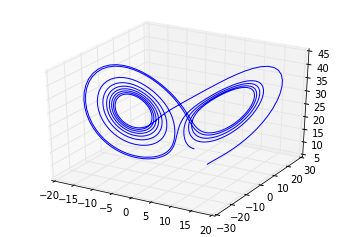

In [6]:
q = lorenz.lorenz([5.0, 5.0, 5.0], 0.0, 10.0)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(q[:,0], q[:,1], q[:,2])

plt.show()